In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
import sys
from importlib import reload
from pathlib import Path
import scanpy as sc
from pylab import rcParams
from matplotlib.patches import Patch
import re
import seaborn as sns
import glob

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import scvelo as scv
scv.logging.print_version()


scv.settings.verbosity = 3  # show errors(0), warnings(1), info(2), hints(3)
scv.settings.set_figure_params('scvelo')  # for beautified visualization

%matplotlib inline

Running scvelo 0.2.2 (python 3.8.3) on 2021-06-16 17:49.


In [2]:
###----- Get dir & load / reload packages
try:
    code_dir
except NameError:
    print("Start")
    code_dir = os.getcwd()
    base_dir = code_dir.replace("/plotting_codes","")
    tools_dir = base_dir + "/tools"

    sys.path.insert(1, tools_dir)
    import sc_addons
    import sc_pl_addons
else:
    print("Reload")
    reload(sc_addons)
    reload(sc_pl_addons)

Start


In [3]:
## ----- Setup working dir
sp_name = "1_IL2RAKO"
analysis_name = ["0", "all"] 

wk_dir = base_dir + "/9_Figures/%s/%s_%s"%(sp_name, analysis_name[0], analysis_name[1])
Path(wk_dir).mkdir(parents=True, exist_ok=True)
os.chdir(wk_dir)

print(sp_name)

1_IL2RAKO


In [4]:
###----- old - new cluster names
order_file = '/media/pipkin/ROCKET-PRO/CD8_DEV_SC/1_IL2RAKO/1_Scanpy/0-all_Scanpy_out/0_sum/1_IL2RAKO_obs_louvainAvg.csv'
order_df = pd.read_csv(order_file)
louvain_new_ordered = order_df['louvain_new_label'].tolist()
louvain_old_ordered = order_df['louvain'].tolist()

In [5]:
adata_h5ad = '%s/%s/1_Scanpy'%(base_dir, sp_name) + '/%s-%s_Scanpy_out/%s_paga.h5ad'%(analysis_name[0], analysis_name[1], sp_name)
adata = sc.read_h5ad(adata_h5ad)

#--- Match old & new louvain levels
adata.obs['louvain_old'] = adata.obs['louvain']
adata.uns['louvain_old_colors'] = adata.uns['louvain_colors']
adata.obs['louvain'] = [ louvain_new_ordered[louvain_old_ordered.index(int(x))] for x in adata.obs['louvain'] ]
category_order = order_df.sort_values('louvain')['louvain_new_label'].tolist()
adata.obs['louvain'] = pd.Categorical(adata.obs['louvain'].tolist(), categories=category_order) # The key is to set categories according to original order...
adata.uns['louvain_colors'] = ['slategray',  'orchid','orange', 'sienna', 'dodgerblue','dimgray',  'lightgray' ,'purple', 'forestgreen','red']

adata.obs['cell_id'] = adata.obs.index.tolist()

###----- Create object with louvain clusters ranekd by new order
old_louvain_order = adata.obs['louvain'].cat.categories.tolist()
old_louvain_colors = adata.uns['louvain_colors']
new_louvain_colors = [old_louvain_colors[old_louvain_order.index(x)] for x in louvain_new_ordered]

adata_neworder = adata.copy()
adata_neworder.obs['louvain'] = pd.Categorical(adata.obs['louvain'].tolist(), categories=louvain_new_ordered)
adata_neworder.uns['louvain_colors'] = new_louvain_colors

highly_variable_genes = adata.var.index.tolist()

## Merge P0

In [6]:
adata_neworder_mergeP0 = adata_neworder.copy()
louvain_new_ordered_mergeP0 = [x for x in louvain_new_ordered if '.' not in x]
adata_neworder_mergeP0.obs['louvain'] = pd.Categorical([x.split(".")[0] for x in adata.obs['louvain']], categories = louvain_new_ordered_mergeP0)
adata_neworder_mergeP0.uns['louvain_colors'] = ['slategray', 'orchid', 'red', 'forestgreen', 'dodgerblue', 'sienna', 'orange', 'purple']

In [7]:
adata_ko = adata[adata.obs["cell_type"] == "CD25KO", :]
adata_wt = adata[adata.obs["cell_type"] == "CD25WT", :]

In [7]:
# Calculate radius of louvain cluster circles
nodeplot_size_col_df = pd.DataFrame()
nodeplot_size_col_df['colors'] = adata.uns['louvain_colors']
nodeplot_size_col_df.index = adata.obs['louvain'].cat.categories.tolist()
nodeplot_size_col_df.index.name = 'louvain'

#--- all
size_series = adata.obs.groupby('louvain').count()['cell_type']
nodeplot_size_col_df['all'] = size_series

#--- Act
size_series = adata[adata.obs['cell_type'] != 'P14NAV'].obs.groupby('louvain').count()['cell_type']
nodeplot_size_col_df['act'] = size_series

#--- KO
size_series = adata[adata.obs['cell_type'] == 'CD25KO'].obs.groupby('louvain').count()['cell_type']
nodeplot_size_col_df['CD25KO'] = size_series

#--- WT
size_series = adata[adata.obs['cell_type'] == 'CD25WT'].obs.groupby('louvain').count()['cell_type']
nodeplot_size_col_df['CD25WT'] = size_series

nodeplot_size_col_df = nodeplot_size_col_df.loc[louvain_new_ordered]
nodeplot_size_col_df.to_csv('/media/pipkin/ROCKET-PRO/CD8_DEV_SC/9_Figures/1_IL2RAKO/nodeplot_size_color.csv')

# 1. Scatterplots

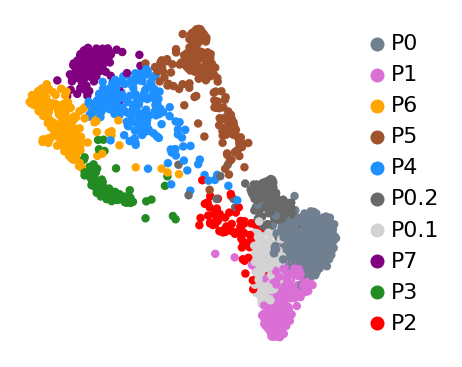

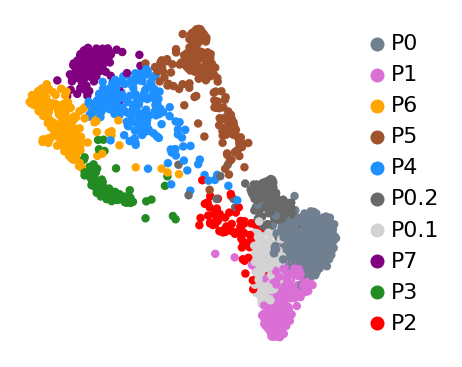

In [7]:
### New louvain cluster numeric order plot
save_name = '_louvain_new_scatter_with_leg'

### Plot
rcParams['figure.figsize'] = 3, 3

sc.pl.draw_graph(adata, color=['louvain'], frameon=False, save = save_name + '.png', title='')
sc.pl.draw_graph(adata, color=['louvain'], frameon=False, save = save_name + '.pdf', title='')

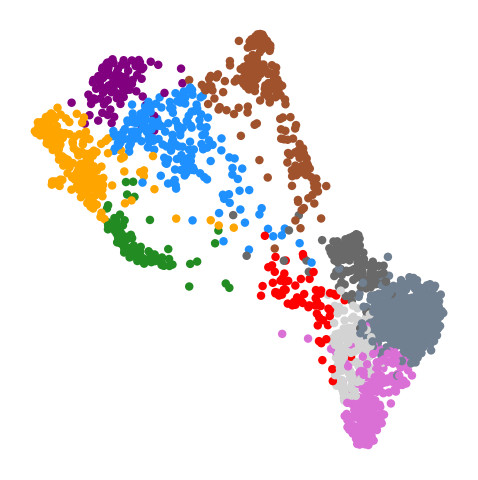

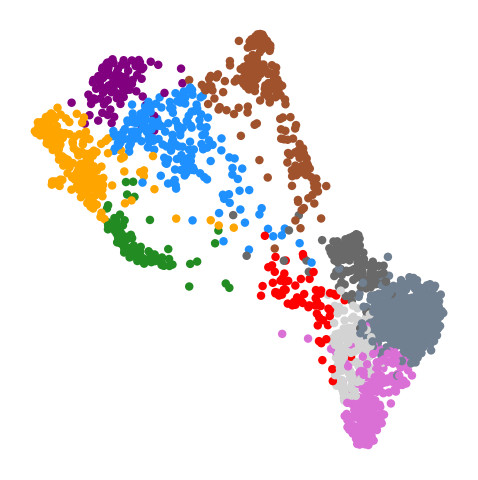

In [31]:
### New louvain cluster numeric order plot
save_name = '_louvain_new_scatter'

### Plot
rcParams['figure.figsize'] = 4,4

sc.pl.draw_graph(adata, color=['louvain'], frameon=False, legend_loc=None, save = save_name + '.png', title='')
sc.pl.draw_graph(adata, color=['louvain'], frameon=False, legend_loc=None, save = save_name + '.pdf', title='')

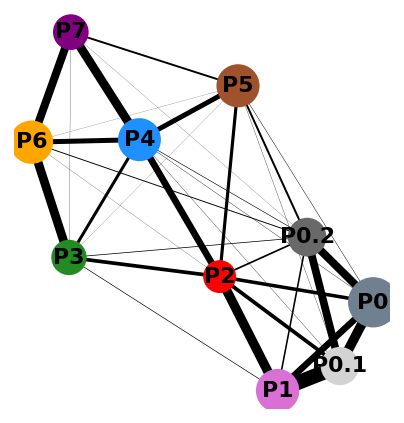

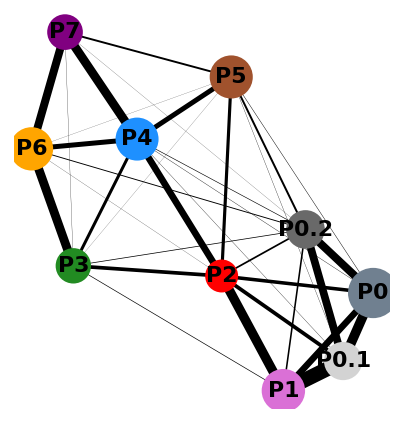

In [7]:
### New louvain cluster numeric order - Node plot
save_name = 'louvain_new_node'

### Plot
rcParams['figure.figsize'] = 3.5, 3.3
sc.pl.paga(adata, color=['louvain'], node_size_scale=2.5, frameon=False, save=save_name + '.png')
sc.pl.paga(adata, color=['louvain'], node_size_scale=2.5, frameon=False, save=save_name + '.pdf')

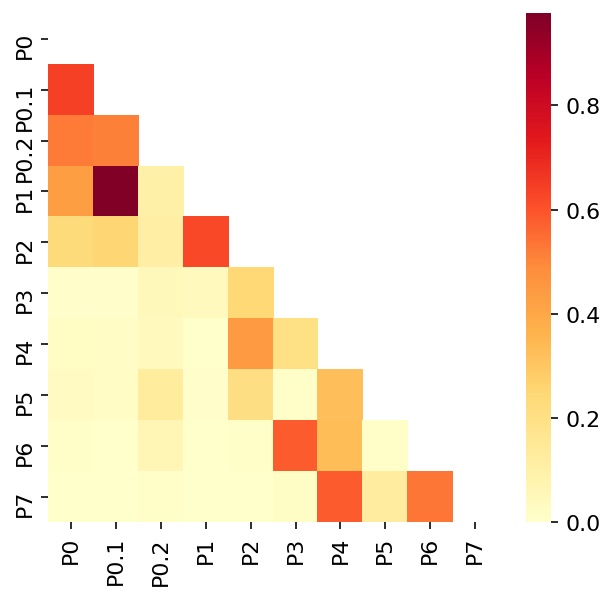

In [8]:
### Correlation heatmap
save_name = 'paga_corr'

### Plot
rcParams['figure.figsize'] = 5, 4.5

conn_df = pd.DataFrame.sparse.from_spmatrix(adata.uns['paga']['connectivities'])
conn_df.columns = old_louvain_order
conn_df.index = old_louvain_order
conn_df = conn_df[louvain_new_ordered]
conn_df = conn_df.loc[louvain_new_ordered]

mask = np.triu(np.ones_like(conn_df, dtype=bool))
corr_plot = sns.heatmap(conn_df, mask=mask, cmap="YlOrRd")
corr_plot.figure.savefig(save_name + ".png")
corr_plot.figure.savefig(save_name + ".pdf")

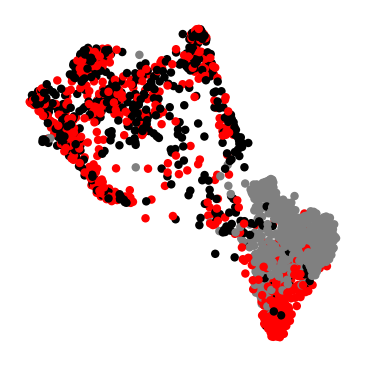

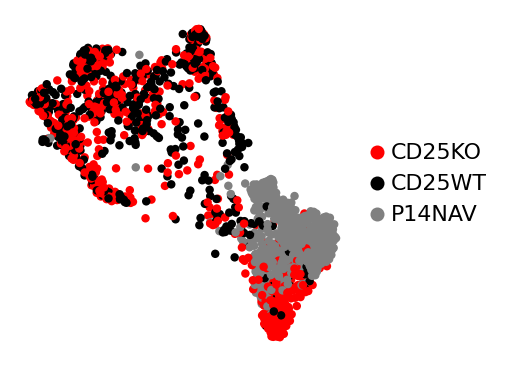

In [9]:
### Hightlight by day
save_name = '_KO_vs_WT'

### Plot
adata.uns['cell_type_colors'] = np.array(['red', 'black', 'grey'])
rcParams['figure.figsize'] = 3, 3
sc.pl.draw_graph(adata, color=['cell_type'], frameon=False, save=save_name + '.png',  legend_loc=None, title='')
sc.pl.draw_graph(adata, color=['cell_type'], frameon=False, save=save_name + '.pdf', title='')

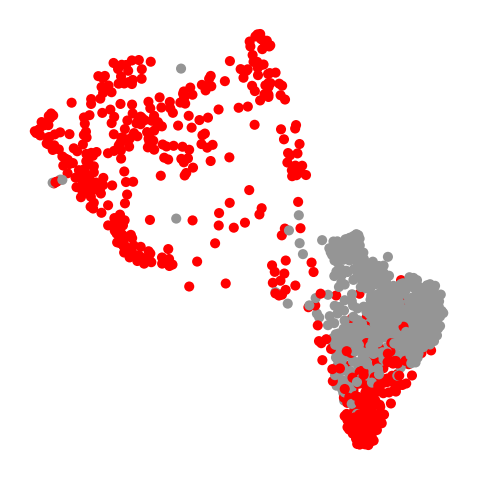

In [35]:
### Hightlight by day
save_name = '_KO-Nav'

### Plot
rcParams['figure.figsize'] = 4,4

adata_plot = adata[adata.obs['cell_type'] != "CD25WT"]

sc.pl.draw_graph(adata_plot, color=['CD25KO'], frameon=False, save=save_name + '.png',  legend_loc=None, title="")

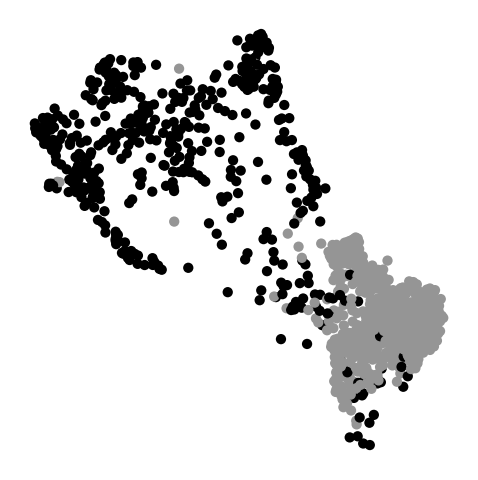

In [37]:
### Hightlight by day
save_name = '_WT-Nav'

### Plot
rcParams['figure.figsize'] = 4,4

adata_plot = adata[adata.obs['cell_type'] != "CD25KO"]

sc.pl.draw_graph(adata_plot, color=['CD25WT'], frameon=False, save=save_name + '.png',  legend_loc=None, title="")

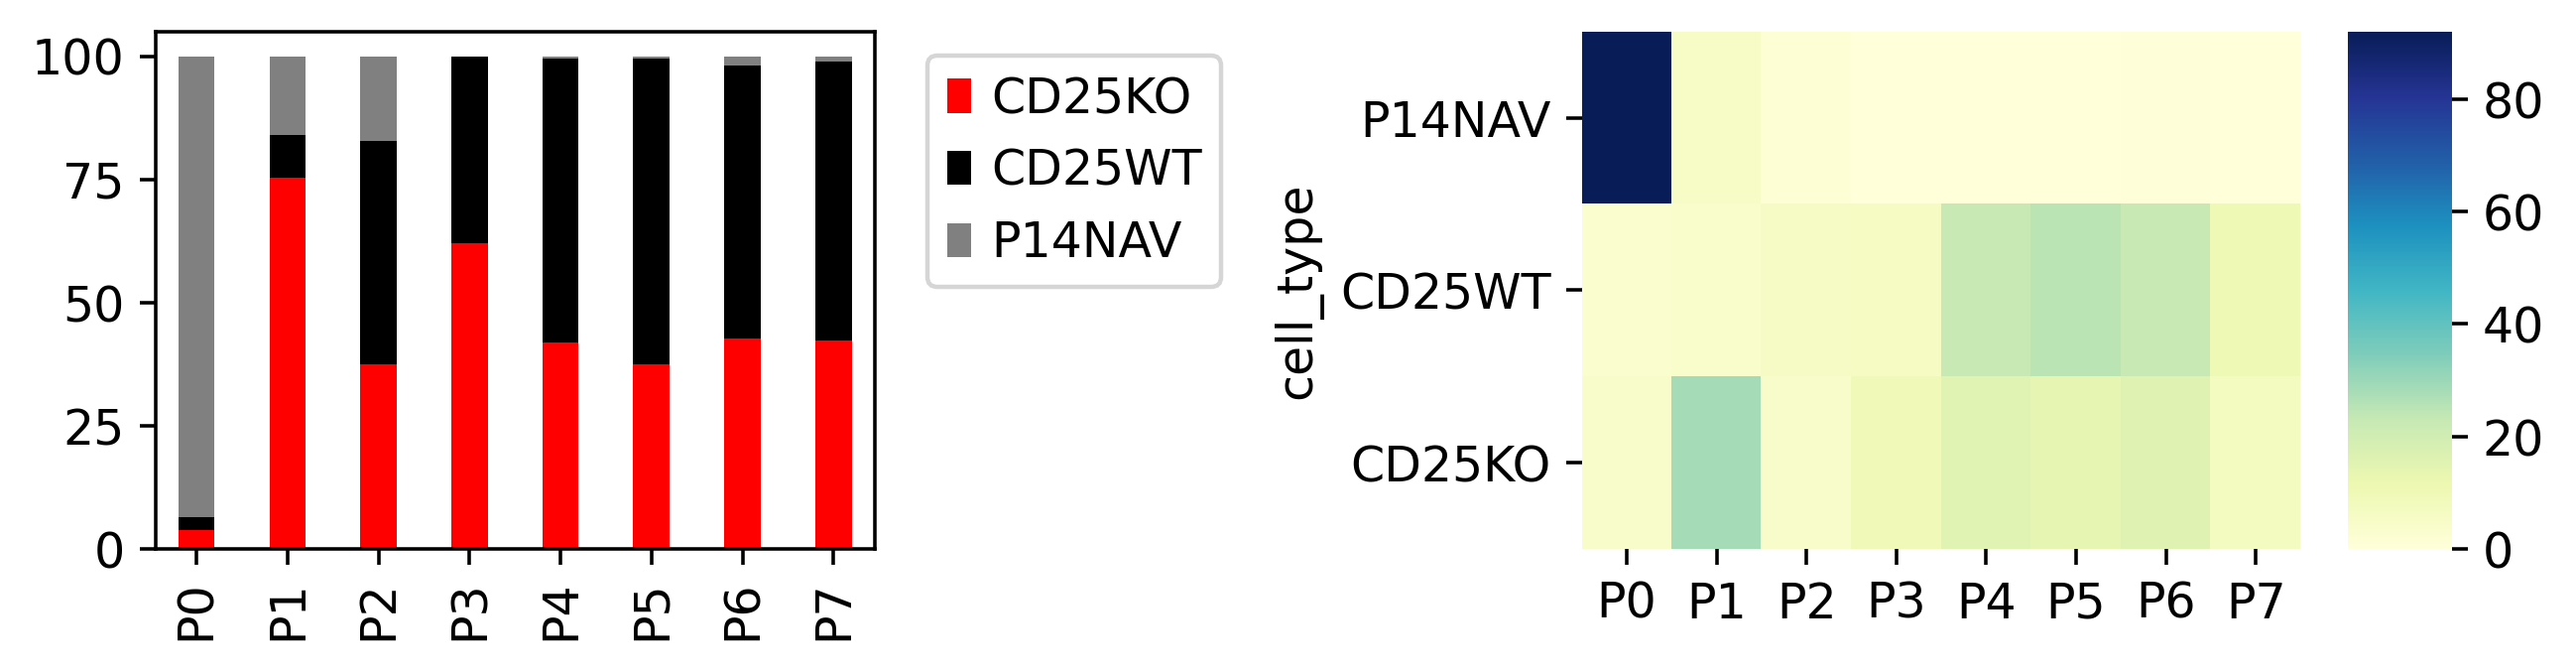

In [70]:
### Hightlight by day
save_name = 'Louvain_cell-type_distribution'

### Plot
fig, axes = plt.subplots(ncols=2, nrows=1, sharey=False, figsize=(8,2), constrained_layout = True, dpi=160)

col_list = ['red', 'black', 'grey']
sum_df = sc_pl_addons.count_pctg_stack_bars(adata_neworder_mergeP0,  'louvain', 'cell_type','cell_id', 
                                   None, None, axes[0], col_list,True)

key1 = 'louvain'
key2 = 'cell_type'
count = 'cell_id'
sum_df = adata_neworder_mergeP0.obs.reset_index()[[key1, key2, count]].drop_duplicates(count).groupby([key1, key2]).count()[[count]].unstack(key1)
sum_df.columns = [x[1] for x in sum_df.columns.values] 
sum_df[np.isnan(sum_df)] = 0

sum_df_pctg = sum_df.copy()
for i in range(0, len(sum_df)):
    sum_df_pctg.iloc[i] = sum_df_pctg.iloc[i] / sum(sum_df_pctg.iloc[i]) * 100
sum_df_cols = sum_df.columns.tolist()
sum_df_cols = sorted(sum_df_cols, key=lambda x: int(re.findall("\d+", x)[0]))
sum_df_pctg = sum_df_pctg[sum_df_cols]
sum_df = sum_df[sum_df_cols]

sum_df_plot = sum_df_pctg.loc[['P14NAV', 'CD25WT', 'CD25KO'], :]
sns.heatmap(sum_df_plot, cmap='YlGnBu', ax=axes[1])

plt.show()
fig.savefig(save_name + '.png')
fig.savefig(save_name + '.pdf')
plt.close()

In [11]:
# Chi-squre test for each cluster comparing WT & KO
from scipy.stats import chi2_contingency
import csv

sum_df_test = sum_df[["P2","P3","P4","P5","P6","P7"]]
sum_df_test = sum_df_test.loc[['CD25KO', 'CD25WT']]

out_name = 'chisq_clusters_exclude_P0-P1.csv'
WT_KO_sum = sum_df_test.sum(axis=1)
with open(out_name, "w") as fout:
    wfout = csv.writer(fout, delimiter=",")
    for cluster in sum_df_test.columns:
        KO_list = [sum_df_test.loc[['CD25KO']][cluster][0] , WT_KO_sum['CD25KO'] - sum_df_test.loc[['CD25KO']][cluster][0]]
        WT_list = [sum_df_test.loc[['CD25WT']][cluster][0] , WT_KO_sum['CD25WT'] - sum_df_test.loc[['CD25WT']][cluster][0]]
        wfout.writerow(["%s contingency table"%cluster])
        wfout.writerow(["", cluster, "other"])
        KO_list_pctg = ["{} ({:.1f}%)".format(int(x), x/sum(KO_list)*100) for x in KO_list]
        WT_list_pctg = ["{} ({:.1f}%)".format(int(x), x/sum(WT_list)*100) for x in WT_list]
        wfout.writerow(["KO"] + KO_list_pctg)
        wfout.writerow(["WT"] + WT_list_pctg)
        wfout.writerow(["Total"] + [KO_list[0]+WT_list[0], KO_list[1]+WT_list[1]])
        g, p, dof, expctd = chi2_contingency([KO_list, WT_list])
        wfout.writerow(["chisq", g])
        wfout.writerow(["pval", p])
        wfout.writerow([])

In [10]:
# Chi-squre test for each cluster comparing WT & KO
from scipy.stats import chi2_contingency
import csv

sum_df_test = sum_df[["P1","P2","P3","P4","P5","P6","P7"]]
sum_df_test = sum_df_test.loc[['CD25KO', 'CD25WT']]

out_name = 'chisq_clusters_exclude_P0.csv'
WT_KO_sum = sum_df_test.sum(axis=1)
with open(out_name, "w") as fout:
    wfout = csv.writer(fout, delimiter=",")
    for cluster in sum_df_test.columns:
        KO_list = [sum_df_test.loc[['CD25KO']][cluster][0] , WT_KO_sum['CD25KO'] - sum_df_test.loc[['CD25KO']][cluster][0]]
        WT_list = [sum_df_test.loc[['CD25WT']][cluster][0] , WT_KO_sum['CD25WT'] - sum_df_test.loc[['CD25WT']][cluster][0]]
        wfout.writerow(["%s contingency table"%cluster])
        wfout.writerow(["", cluster, "other"])
        KO_list_pctg = ["{} ({:.1f}%)".format(int(x), x/sum(KO_list)*100) for x in KO_list]
        WT_list_pctg = ["{} ({:.1f}%)".format(int(x), x/sum(WT_list)*100) for x in WT_list]
        wfout.writerow(["KO"] + KO_list_pctg)
        wfout.writerow(["WT"] + WT_list_pctg)
        wfout.writerow(["Total"] + [KO_list[0]+WT_list[0], KO_list[1]+WT_list[1]])
        g, p, dof, expctd = chi2_contingency([KO_list, WT_list])
        wfout.writerow(["chisq", g])
        wfout.writerow(["pval", p])
        wfout.writerow([])

## Expression heatmap

In [10]:
#gs_plot_use_file = '/media/pipkin/ROCKET-PRO/T_cell_signature_Reference/Y_annotated/anno_plotuse_gs_20200928.csv'
#gs_plot_use_df = pd.read_csv(gs_plot_use_file)
#gs_use = gs_plot_use_df[gs_plot_use_df['plot_use'].notnull()]['gs_name'].tolist()

#gs_file = '/media/pipkin/ROCKET-PRO/T_cell_signature_Reference/X_GeneSignatures_mm/all_mouse_T_cell_signatures.csv'
#gs_df = pd.read_csv(gs_file)
#gs_df_use = gs_df[[True if x in gs_use else False for x in gs_df['gs_name']]]
#genes_use = list(set(gs_df_use['gene_symbol'].tolist()))

### Intersect chromatin regulators & TF & cell surface receptors
surface_df = pd.read_csv('https://raw.githubusercontent.com/Yolanda-HT/SurfaceMarkers_Cytokines/master/2_compiled/MM_MARKERS.csv')
surface_genes = surface_df['gene_name'].tolist()
crf_df = pd.read_csv('https://raw.githubusercontent.com/ScrippsPipkinLab/CRF_Screen/master/Ref/CRF_all.csv?token=AGIX2OYDU5Y2ACKN2IG7HXTAIFEKU')
crf_genes = crf_df['gene_name'].tolist() + [x for x in crf_df['Alternative'].tolist() if str(x) != 'nan']
tf_df = pd.read_csv('https://raw.githubusercontent.com/Yolanda-HT/TFclassDataCollection/master/Ravasi_TF.csv')
tf_genes = tf_df['symbol'].tolist()
all_genes = list(set(surface_genes + crf_genes + tf_genes))

genes_use = all_genes

In [11]:
diff_dir = '/media/pipkin/ROCKET-PRO/CD8_DEV_SC/1_IL2RAKO/1_Scanpy/0-all_Scanpy_out/2_DE/eachCluster_vs_All_newNames'
diff_files = glob.glob("%s/*.csv"%diff_dir)

padj_list = [ 't-test_padj']
fc = 't-test_logfc'

louvain_sig_genes_plot_dict = {}
for i in diff_files:
    i_name = i.split("/")[-1].split("_")[0]
    
    i_df = pd.read_csv(i)


    i_df_sig = i_df
    for padj in padj_list:
        i_df_sig = i_df_sig[i_df_sig[padj] <= 0.05]

    i_df_sig = i_df_sig[i_df_sig[fc] > 1]

    i_df_sig_use = i_df_sig[[True if x in genes_use else False for x in i_df_sig['gene_names']]] # Select only the genes that are in GSEA
    #i_df_sig_use = i_df_sig[[False if (x.startswith("Rps") or x.startswith("Rpl")) else True for x in i_df_sig['gene_names']]] # Remove genes that are ribosomal
    i_df_sig_use = i_df_sig_use.sort_values(['t-test_score'], ascending=False)
    
    louvain_sig_genes_plot_dict[i_name] = pd.Series(i_df_sig_use['gene_names'].tolist())
    print("%s: %s signature genes"%(i_name, len(i_df_sig_use)))

louvain_sig_genes_plot_df = pd.DataFrame(louvain_sig_genes_plot_dict)
louvain_sig_genes_plot_df.to_csv("louvain_signature_genes.csv", index=False)
louvain_sig_genes_plot_df.to_csv("louvain_signature_genes_neworder.csv", index=False)

P0: 81 signature genes
P1: 17 signature genes
P2: 101 signature genes
P3: 49 signature genes
P4: 140 signature genes
P5: 208 signature genes
P6: 65 signature genes
P7: 44 signature genes


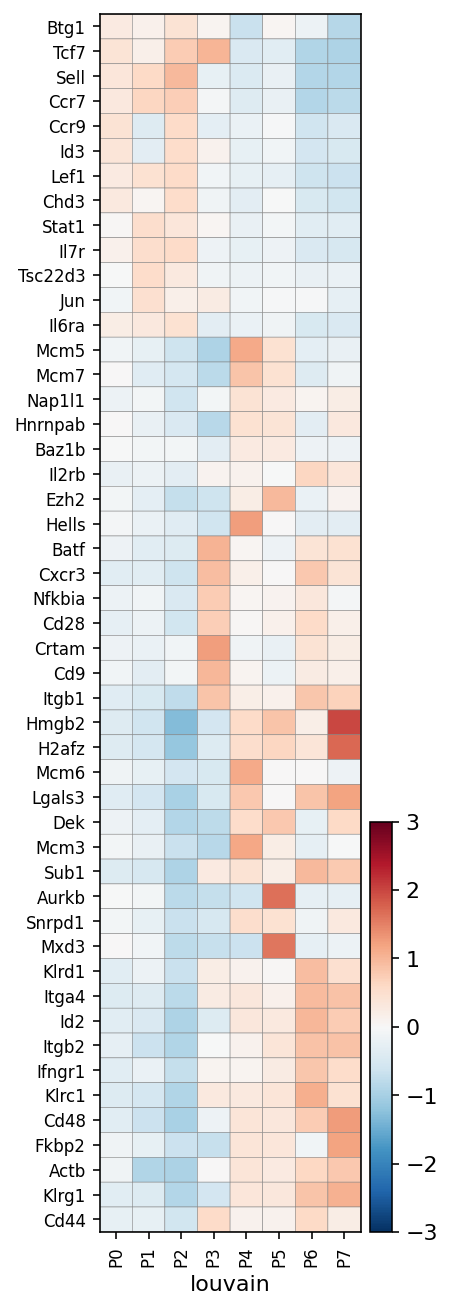

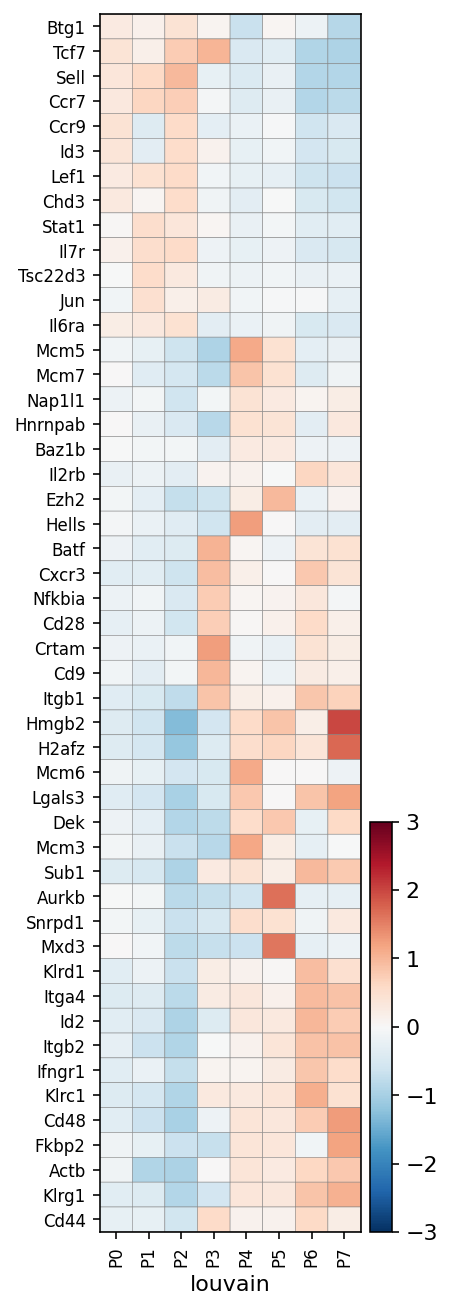

In [12]:
### Heatmap for signature genes of louvain clusters
save_name = 'Louvain_cluster_signature_genes'

### Plot
marker_genes = []
for i in louvain_new_ordered_mergeP0:
    i_markers = louvain_sig_genes_plot_df[i].tolist()
    i_markers = [x for x in i_markers if x in highly_variable_genes]
    marker_genes = marker_genes + i_markers[:8]

marker_genes_use = []
for i in marker_genes:
    if i not in marker_genes_use:
        marker_genes_use.append(i)

marker_genes_use.append('Klrg1')
marker_genes_use.append('Cd44')
        
adata_neworder_mergeP0.layers['scaled'] = sc.pp.scale(adata_neworder_mergeP0, copy=True).X
sc.pl.matrixplot(adata_neworder_mergeP0, marker_genes_use, layer='scaled',groupby='louvain', vmin=-3, vmax=3, swap_axes=True, save=save_name + ".png")
sc.pl.matrixplot(adata_neworder_mergeP0, marker_genes_use, layer='scaled',groupby='louvain', vmin=-3, vmax=3, swap_axes=True, save=save_name + ".pdf")
# Save gene name list
pd.DataFrame({"gene_name": marker_genes_use}).to_csv(save_name + ".csv", index=False)

*Signature gene average expression*

In [21]:
all_sig_genes = louvain_sig_genes_plot_df.values.tolist()
all_sig_genes = [item for sublist in all_sig_genes for item in sublist]
all_sig_genes = [x for x in all_sig_genes if str(x) != 'nan']
all_sig_genes = list(set(all_sig_genes))

In [22]:
raw_df = pd.DataFrame.sparse.from_spmatrix(adata_neworder_mergeP0.raw.X)
raw_df.columns = adata_neworder_mergeP0.raw.var_names
raw_df.index = adata_neworder_mergeP0.raw.obs_names
raw_df = raw_df[all_sig_genes]

In [28]:
raw_df_calc = raw_df.join(adata_neworder_mergeP0.obs[['louvain']])
raw_df_calc_mean = raw_df_calc.groupby('louvain').mean()
raw_df_calc_mean = raw_df_calc_mean.T[louvain_new_ordered_mergeP0]
raw_df_calc_mean.to_csv("louvain_signature_genes_neworder_RawExpr_avg_louvain.csv")

In [41]:
import itertools
# Create order
adata_neworder_mergeP0.obs['cell_type_simp'] = [x.replace("CD25", "").replace("P14", "") for x 
                                                in adata_neworder_mergeP0.obs['cell_type']]

adata_neworder_mergeP0.obs['louvain_celltype_new'] = [x+"-"+y for index,(x,y) in 
                                                      enumerate(zip(adata_neworder_mergeP0.obs['cell_type_simp'], 
                                                                    adata_neworder_mergeP0.obs['louvain']))]

raw_df_calc = raw_df.join(adata_neworder_mergeP0.obs[['louvain_celltype_new']])
raw_df_calc_mean = raw_df_calc.groupby('louvain_celltype_new').mean()

louvain_celltype_order = list(itertools.chain.from_iterable(itertools.repeat(x, 2) 
                                                            for x in louvain_new_ordered_mergeP0[1:]))
acn_list = ['WT', 'KO'] * (len(louvain_new_ordered) - 1)
louvain_celltype_order = [x+'-'+y for index, (x,y) in 
                         enumerate(zip( acn_list, louvain_celltype_order))]
louvain_celltype_order = ['NAV-P0'] + louvain_celltype_order

raw_df_calc_mean = raw_df_calc_mean.T[louvain_celltype_order]
raw_df_calc_mean.to_csv("louvain_signature_genes_neworder_RawExpr_avg_louvain_celltype.csv")

## Expression of key genes in KO versus WT

In [197]:
wt_vs_ko_sig_genes_dir = wk_dir + '/WT_vs_KO_sig_genes'
Path(wt_vs_ko_sig_genes_dir).mkdir(parents=True, exist_ok=True)
os.chdir(wt_vs_ko_sig_genes_dir)

In [198]:
adata_use = adata_wt

expr_df = pd.DataFrame(adata_use.X)
expr_df.columns = adata_use.var.index
expr_df.index = adata_use.obs.index
expr_df['louvain'] = adata_use.obs['louvain']
mean_df = expr_df.groupby('louvain').mean()

mean_df_wt = mean_df

In [199]:
adata_use = adata_ko

expr_df = pd.DataFrame(adata_use.X)
expr_df.columns = adata_use.var.index
expr_df.index = adata_use.obs.index
expr_df['louvain'] = adata_use.obs['louvain']
mean_df = expr_df.groupby('louvain').mean()

mean_df_ko = mean_df

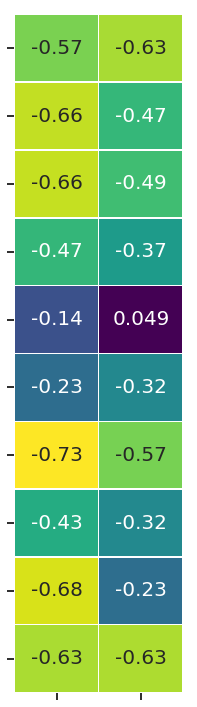

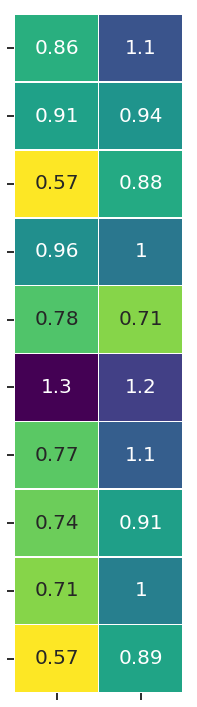

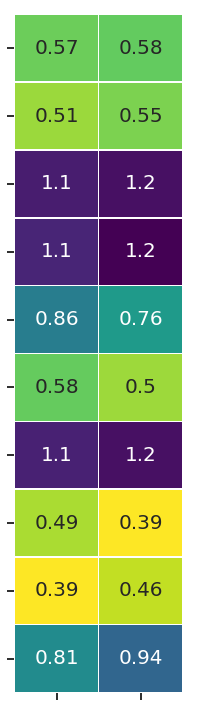

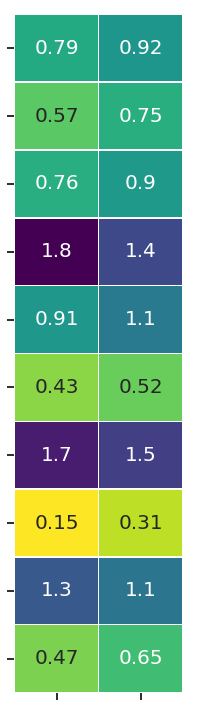

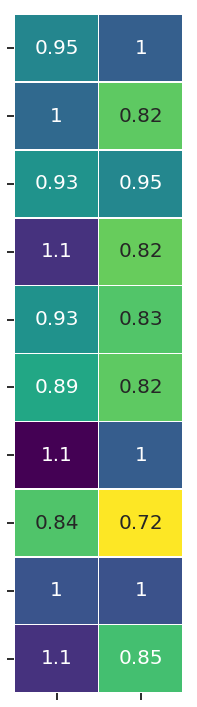

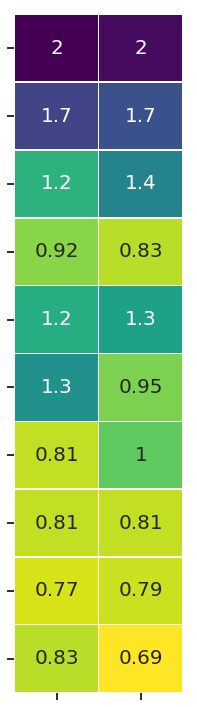

In [206]:
for cluster_use in ["P2","P3","P4","P5","P6","P7"]:
    marker_genes = louvain_sig_genes_plot_df[cluster_use].tolist()
    marker_genes = [x for x in marker_genes if x in highly_variable_genes][:10]

    cluster_avg_df = pd.DataFrame()
    cluster_avg_df['wt'] = mean_df_wt[marker_genes].loc[cluster_use].tolist()
    cluster_avg_df['ko'] = mean_df_ko[marker_genes].loc[cluster_use].tolist()
    cluster_avg_df.index = marker_genes
    cluster_avg_df.to_csv("%s_WT-vs-KO_sig_genes.csv"%cluster_use)

    ### Plot
    rcParams['figure.figsize'] = 5,8
    sns.heatmap(cluster_avg_df, cmap="viridis_r")
    plt.savefig("%s_WT-vs-KO_sig_genes.png"%cluster_use)
    plt.close()
    
    rcParams['figure.figsize'] = 1.5,6
    heatmap = sns.heatmap(cluster_avg_df, cmap="viridis_r", linecolor='white', linewidth=0.2, annot=True, cbar=False)
    heatmap.set(xticklabels=[])
    heatmap.set(yticklabels=[])
    plt.savefig("%s_WT-vs-KO_sig_genes_nolabels.png"%cluster_use)
    plt.show()
    plt.close()